In [1]:
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from GridWorld_v1 import GridWorld_v1

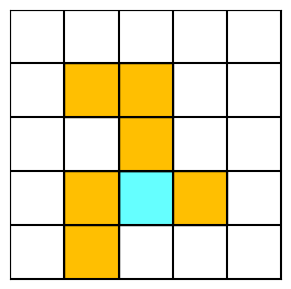

In [2]:
desc = rows = 5  # 记得行数和列数这里要同步改
columns = 5
desc = [".....",".##..","..#..",".#T#.",".#..."]

gridworld = GridWorld_v1(forbidden_area_score=-1, score=1,desc=desc) 
print(gridworld.animator.fig.get_facecolor())
gridworld.show()

In [3]:
def compute_advantage(gamma: int, lmbda: int, td_delta: torch.Tensor):
    td_delta = td_delta.detach().numpy()
    advantage_list = []
    advantage = 0
    for delta in td_delta[::-1]:
        advantage = gamma * lmbda * advantage + delta
        advantage_list.append(advantage)
    advantage_list.reverse()
    # print(f"{advantage_list=}")
    return torch.tensor(advantage_list, dtype=torch.float)

In [4]:
class ValueNet(torch.nn.Module):
    """只有一层隐藏层的Q网络"""

    def __init__(self,state_dim,hidden_dim):
        super().__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, 1)
        self.fc3 = torch.nn.Linear(hidden_dim, hidden_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))  # 隐藏层使用ReLU激活函数
        x = F.relu(self.fc3(x))
        return self.fc2(x)

In [5]:
class PolicyNet(torch.nn.Module):
    """只有一层隐藏层的Q网络"""

    def __init__(self,state_dim,hidden_dim,action_dim):
        super().__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)
        self.fc3 = torch.nn.Linear(hidden_dim, hidden_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))  # 隐藏层使用ReLU激活函数
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc2(x))
        return F.softmax(x,dim=1)  # 输出层不使用激活函数

In [6]:
class PPO:
    def __init__(self,state_dim, hidden_dim, action_dim, actor_lr, critic_lr, 
                 lmbda, epochs,eps, gamma, device):
        self.actor = PolicyNet(state_dim, hidden_dim, action_dim).to(device)
        self.critic = ValueNet(state_dim, hidden_dim).to(device)
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=actor_lr)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=critic_lr)
        self.gamma = gamma
        self.lmbda = lmbda
        self.epochs = epochs
        self.eps = eps
        self.device = device

    def take_action(self, state):
        state = torch.tensor([state], dtype=torch.float).to(self.device)
        probs = self.actor(state)
        action_dist = torch.distributions.Categorical(probs)
        action = action_dist.sample()
        return action.item()

    def update(self, transition_dict):
        states = torch.tensor(transition_dict["states"], dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict["actions"]).view(-1,1).to(self.device)
        rewards = torch.tensor(transition_dict["rewards"], dtype=torch.float).view(-1,1).to(self.device)
        next_states = torch.tensor(transition_dict["next_states"], dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict["dones"], dtype=torch.float).view(-1,1).to(self.device)
        td_target = rewards + self.gamma * self.critic(next_states) * (1-dones)
        td_delta = td_target - self.critic(states)
        # td_delta = td_delta.detach()
        advantage = compute_advantage(self.gamma, self.lmbda, td_delta)
        old_log_probs = torch.log(self.actor(states).gather(1, actions)).detach()
        for _ in range(self.epochs):
            log_probs = torch.log(self.actor(states).gather(1, actions))
            ratio = torch.exp(log_probs - old_log_probs)
            surr1 = ratio * advantage
            surr2 = torch.clamp(ratio, 1-self.eps, 1+self.eps) * advantage
            actor_loss = torch.mean(-torch.min(surr1, surr2))
            critic_loss = torch.mean(F.mse_loss(self.critic(states), td_target.detach()))
            self.actor_optimizer.zero_grad()
            self.critic_optimizer.zero_grad()
            actor_loss.backward()
            critic_loss.backward()
            self.actor_optimizer.step()
            self.critic_optimizer.step()

    def save(self, path):
        torch.save(self.actor.state_dict(), path)


In [7]:
actor_lr = 1e-4
critic_lr = 1e-3
num_episodes = 10000
hidden_dim = 128
gamma = 0.99
lmbda = 0.99
epochs = 10
eps = 0.2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
env = gridworld
state_dim = 2
action_dim = 5

agent = PPO(
    state_dim,
    hidden_dim,
    action_dim,
    actor_lr,
    critic_lr,
    lmbda,
    epochs,
    eps,
    gamma,
    device,
)

In [8]:
max_v = -100
max_step = 2000
for i in range(num_episodes):
    state = gridworld.reset()
    step = 0
    done = False
    episode_reward = 0
    transiton_dict = {
                "states": [],
                "actions": [],
                "rewards": [],
                "next_states": [],
                "dones": [],
            }

    while not done:
        step += 1
        action = agent.take_action(state)
        next_state, reward, done = gridworld.step(state, action)
        transiton_dict["states"].append(state)
        transiton_dict["actions"].append(action)
        transiton_dict["next_states"].append(next_state)
        transiton_dict["rewards"].append(reward)
        transiton_dict["dones"].append(done)
        state = next_state
        episode_reward += reward
        if step >= max_step:
            done = True

    agent.update(transiton_dict)
    if episode_reward >= max_v:
        agent.save("model.pth")
        max_v = episode_reward
    if i % 30 == 0:
        print(f"episode: {i}, value: {episode_reward}")

/var/folders/j6/x5g6fdss0lx3bjtvj9_5cmwh0000gn/T/ipykernel_74052/1557795034.py:10: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:281.)
  return torch.tensor(advantage_list, dtype=torch.float)


episode: 0, value: -17.0
episode: 30, value: -19.0
episode: 60, value: 0.0
episode: 90, value: -14.0
episode: 120, value: -1.0
episode: 150, value: 1.0
episode: 180, value: 1.0
episode: 210, value: -3.0
episode: 240, value: 1.0
episode: 270, value: -9.0
episode: 300, value: 0.0
episode: 330, value: -13.0
episode: 360, value: -3.0
episode: 390, value: 1.0
episode: 420, value: -2.0
episode: 450, value: -1.0
episode: 480, value: 0.0
episode: 510, value: 0.0
episode: 540, value: -1.0
episode: 570, value: 1.0
episode: 600, value: -3.0
episode: 630, value: -2.0
episode: 660, value: 0.0
episode: 690, value: -1.0
episode: 720, value: -11.0
episode: 750, value: -3.0
episode: 780, value: 0.0
episode: 810, value: 0.0
episode: 840, value: 0.0
episode: 870, value: 0.0
episode: 900, value: 0.0
episode: 930, value: -1.0
episode: 960, value: 0.0
episode: 990, value: 0.0
episode: 1020, value: 0.0
episode: 1050, value: 1.0
episode: 1080, value: 0.0
episode: 1110, value: -8.0
episode: 1140, value: 0.0
ep

KeyboardInterrupt: 

torch.Size([25, 5])
[[[1.55612270e-06 4.26340830e-06 9.99991059e-01 1.55612270e-06
   1.55612270e-06]
  [1.06396847e-07 1.06396847e-07 9.99999523e-01 1.06396847e-07
   1.06396847e-07]
  [1.45444923e-09 1.45444923e-09 1.00000000e+00 1.45444923e-09
   1.45444923e-09]
  [1.69530830e-11 1.69530830e-11 1.00000000e+00 1.65708641e-10
   1.69530830e-11]
  [2.03073140e-13 2.03073140e-13 1.00000000e+00 2.08695578e-11
   2.03073140e-13]]

 [[6.83216203e-05 1.17663611e-02 9.88028705e-01 6.83216203e-05
   6.83216203e-05]
  [1.73325577e-06 1.73325577e-06 9.99992967e-01 1.73325577e-06
   1.73325577e-06]
  [4.49615563e-08 4.49615563e-08 9.99999642e-01 2.93574260e-07
   4.49615563e-08]
  [6.35189790e-10 6.35189790e-10 1.00000000e+00 5.37710250e-08
   6.35189790e-10]
  [7.91934747e-12 7.91934747e-12 1.00000000e+00 7.25099980e-09
   7.91934747e-12]]

 [[9.41117585e-04 9.87051129e-01 1.18663665e-02 7.07574945e-05
   7.07574945e-05]
  [6.30711322e-04 4.08363715e-03 9.94799376e-01 2.43050046e-04
   2.430500

/var/folders/j6/x5g6fdss0lx3bjtvj9_5cmwh0000gn/T/ipykernel_62802/3222823312.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_net.load_state_dict(torch.load("model.pt

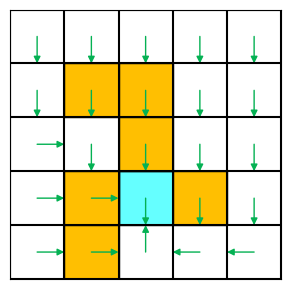

In [142]:
gridworld_idx = [(i, j) for i in range(rows) for j in range(columns)]
gridworld_idx =  torch.tensor(gridworld_idx,dtype=torch.float32)
best_net = PolicyNet(state_dim, hidden_dim, action_dim).to(device)  
best_net.load_state_dict(torch.load("model.pth"))
with torch.no_grad():
    q_tables =best_net(gridworld_idx)
    print(q_tables.shape)
    q_tables = np.array(q_tables).reshape(rows, columns, action_dim)
# print(f"q_tables_shape:{q_tables.shape}")
print(q_tables)
policy = np.argmax(q_tables, axis=2)
gridworld.show_policy(policy)